In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from collections import namedtuple
import copy

import awkward as ak
import uproot
import matplotlib
import matplotlib.pyplot as plt
import mplcyberpunk
import numpy as np
from rich import print

from particle import Particle

from python.analysis import Master, Plots, cross_section, vector

def hist_glow(alpha = 0.03, n = 5, width = 1.05):
    ax = plt.gca()
    for patch in ax.get_children()[:-1]: # last patch in children is the grid
        if type(patch) not in [matplotlib.patches.Polygon, matplotlib.patches.Rectangle]: continue # only add glow to histogram patches
        for i in range(1, n + 1):
            new_patch = copy.copy(patch)

            if new_patch.get_edgecolor() == (0, 0, 0, 0):
                edgecolor = new_patch.get_facecolor()
            else:
                edgecolor = new_patch.get_edgecolor()

            new_patch.set(alpha = alpha, linewidth = new_patch.get_linewidth() + (width * i), edgecolor = edgecolor, facecolor = new_patch.get_facecolor(), zorder = 0.6) # grid lines are hardcoded at zorder 0.5
            ax.add_patch(new_patch)


class Slices:
    """ Describes slices of a variable, equivilant to a list of bin edges but has more functionality. 

    Slice : a Single slice, has properies number (integer) and "position" in the parameter space of the value you want to slice up. 
    """
    Slice = namedtuple("Slice", "num pos")
    def __init__(self, width, _min, _max, reversed : bool = False):
        self.width = width
        self.min = _min
        self.max = _max
        self.reversed = reversed
        
        self.max_num = max(self.num)
        self.min_num = min(self.num)
        self.max_pos = max(self.pos)
        self.min_pos = min(self.pos)


    def __conversion__(self, x):
        """ convert a value to its slice number.

        Args:
            x: value, array of float

        Returns:
            slice: slice number/s
        """
        if self.reversed:
            numerator = self.max - x
        else:
            numerator = x
        c = np.floor(numerator // self.width)
        if hasattr(c, "__iter__"):
            return ak.values_astype(c, int)
        else:
            return int(c)


    def __create_slice__(self, i) -> Slice:
        """ using the slice number, create the Slice object.

        Args:
            i (int): slice number/s

        Returns:
            Slice: slice
        """
        if self.reversed:
            p = self.max - i * self.width
        else:
            p = i * self.width
        return self.Slice(i, p)


    def __call__(self, x):
        """ get the slice number for a set of values

        Args:
            x: values

        Returns:
            array or int: slice numbers
        """
        return self.__create_slice__(self.__conversion__(x))


    def __getitem__(self, i : int) -> Slice:
        """ Creates slices from slice numbers.

        Args:
            i (int): slice number

        Raises:
            StopIteration

        Returns:
            Slice: ith slice
        """
        if i * self.width > (self.max - self.min):
            raise StopIteration
        else:
            if self.reversed:
                return self.__create_slice__(i + self.__conversion__(self.max))
            else:
                return self.__create_slice__(i + self.__conversion__(self.min))

    @property
    def num(self) -> np.array:
        """ Return all slice numbers.

        Returns:
            np.array: slice numbers
        """
        return np.array([ s.num for s in self], dtype = int)

    @property
    def pos(self) -> np.array:
        """ Return all slice positions.

        Returns:
            np.array: slice positions
        """
        return np.array([ s.pos for s in self])


    def pos_to_num(self, pos):
        """ Convert slice positions to numbers

        Args:
            pos: positions

        Returns:
            array or int: slice numbers
        """
        slice_num = self.__conversion__(pos)
        if hasattr(pos, "__iter__"):
            slice_num = ak.where(slice_num > max(self.num), max(self.num), slice_num)
            slice_num = ak.where(slice_num < 0, min(self.num), slice_num)
        else:
            if pos > max(self.pos): 
                slice_num = max(self.num) # above range go into overflow bin
            if pos < 0:
                slice_num = min(self.num) # below range go into the underflow bin
        return slice_num


class GeantCrossSections:
    """ Object for accessing Geant 4 cross sections from the root file generated with Geant4reweight tools.
    """
    labels = {"abs_KE;1" : "absorption", "inel_KE;1" : "quasielastic", "cex_KE;1" : "charge_exchange", "dcex_KE;1" : "double_charge_exchange", "prod_KE;1" : "pion_production", "total_inel_KE;1" : "total_inelastic"}

    def __init__(self, file : str = "data/g4_xs.root", energy_range : list = None) -> None:
        self.file = uproot.open(file) # open root file

        self.KE = self.file["abs_KE;1"].all_members["fX"] # load kinetic energy from one channel (shared for all cross section channels)
        if energy_range:
            self.KE = self.KE[(self.KE <= max(energy_range)) & (self.KE >= min(energy_range))]

        for k in self.file.keys():
            if "KE" in k:
                g = self.file[k]
                setattr(self, self.labels[k], g.all_members["fY"][0:len(self.KE)]) # assign class variables for each cross section channel
        pass

    def __PlotAll(self):
        """ Plot all cross section channels.
        """
        for k in self.labels.values():
            Plots.Plot(self.KE, getattr(self, k), label = k.replace("_", " "), newFigure = False, xlabel = "KE (MeV)", ylabel = "$\sigma (mb)$")

    def Plot(self, xs : str, color : str = None, label : str = None, title : str = None):
        """ Plot cross sections. To be used in conjunction with other plots for comparisons.

        Args:
            xs (str): cross section channel to plot, if given all, will plot all cross section channels
            color (str, optional): colour of single plot. Defaults to None.
            label (str, optional): label of plot, if None, the channel name is used. Defaults to None.
            title (str, optional): title of plot, set to the channel name if label is provided. Defaults to None.
        """
        if xs == "all":
            self.__PlotAll()
        else:
            if label is None:
                label = xs.replace("_", " ")
            else:
                title = xs.replace("_", " ")
            Plots.Plot(self.KE, getattr(self, xs), label = label, title = title, newFigure = False, xlabel = "KE (MeV)", ylabel = "$\sigma (mb)$", color = color)


class ThinSlice:
    """ Methods for implementing the thin slice measurement method.
    """
    @staticmethod
    def CountingExperiment(endPos : ak.Array, channel : ak.Array, slices : Slices) -> tuple[ak.Array, ak.Array]:
        """ Creates the interacting and incident histograms.

        Args:
            endPos (ak.Array): end position of particle or "interaction vertex"
            channel (ak.Array): mask which selects particles which interact in the channel you are interested in
            slices (Slices): spatial slices

        Returns:
            tuple[ak.Array, ak.Array]: n_interact and n_incident histograms
        """
        end_slice_pos = slices.pos_to_num(endPos) # using trajectory points gives wierd results, compare the two to see what is different.
        slice_nums = slices.num

        n_interact = np.histogram(end_slice_pos[channel], slice_nums)[0]

        total_interact = np.histogram(end_slice_pos, slice_nums)[0]
        n_incident = np.cumsum(total_interact[::-1])[::-1]
        return n_interact, n_incident

    @staticmethod
    def MeanSliceEnergy(energy : ak.Array, endPos : ak.Array, slices : Slices) -> tuple[ak.Array, ak.Array]:
        """ Compute the average energy in a spatial slice.

        Args:
            energy (ak.Array): particle energies over its lifetime in the tpc
            endPos (ak.Array): end position of particle or "interaction vertex"
            slices (Slices): spatial slices

        Returns:
            tuple[ak.Array, ak.Array]: means slice energy, error in the mean slice energy
        """
        beam_traj_slice = slices.pos_to_num(endPos)
        slice_nums = slices.num

        counts = np.histogram(ak.ravel(beam_traj_slice), slice_nums)[0] # histogram of positions will give the counts

        sum_energy = np.histogram(ak.ravel(beam_traj_slice), slice_nums, weights = ak.ravel(energy))[0] # total energy in each bin if you weight by energy
        sum_energy_sqr = np.histogram(ak.ravel(beam_traj_slice), slice_nums, weights = ak.ravel(energy)**2)[0] # same as above

        mean_energy = sum_energy / counts

        std_energy = np.sqrt(sum_energy_sqr/counts - 2 * mean_energy * sum_energy / counts + mean_energy**2) # expanded standard deviation so I can calulcate using the histograms
        error_mean_energy = std_energy / np.sqrt(counts)
        return mean_energy, error_mean_energy

    @staticmethod 
    def CrossSection(n_incident : np.array, n_interact : np.array, slice_width : float) -> tuple[np.array, np.array]:
        """ Returns cross section in mb.

        Args:
            n_incident (np.array): incident histogram
            n_interact (np.array): interacting histogram
            slice_width (float): spatial width of thin slice

        Returns:
            tuple[np.array, np.array]: cross section, statistical uncertainty
        """
        xs = np.log(n_incident / (n_incident - n_interact)) # calculate a dimensionless cross section

        v_incident = n_incident # poisson uncertainty
        v_interact = n_interact*(1- (n_interact/n_incident)) # binomial uncertainty

        xs_e = (1/n_incident) * (1/(n_incident - n_interact)) * (n_interact**2 * v_incident + n_incident**2 * v_interact)**0.5

        NA = 6.02214076e23
        factor = 10**27 * cross_section.BetheBloch.A  / (cross_section.BetheBloch.rho * NA * slice_width)

        return factor * xs, abs(factor * xs_e)


class EnergySlice:
    """ Methods for implementing the energy slice measurement method.
    """
    @staticmethod
    def TrunacteSlices(slice_array : ak.Array, energy_slices : Slices) -> ak.Array:
        """ Custom method for truncating slice numbers due to the fact energy slices should be in reverse order vs kinetic energy.

        Args:
            slice_array (ak.Array): slices to truncate
            energy_slices (Slices): energy slices

        Returns:
            ak.Array: truncated slices
        """
        # set minimum to -1 (underflow i.e. energy > plim)
        slice_array = ak.where(slice_array < 0, -1, slice_array)
        # set maxslice (overflow i.e. energy < dE)
        slice_array = ak.where(slice_array > energy_slices.max_num, energy_slices.max_num, slice_array)
        return slice_array

    @staticmethod
    def CountingExperiment(int_energy : ak.Array, ff_energy : ak.Array, outside_tpc : ak.Array, channel : ak.Array, energy_slices : Slices) -> tuple[np.array, np.array]:
        """ Creates the interacting and incident histograms.

        Args:
            int_energy (ak.Array): interacting enrgy
            ff_energy (ak.Array): front facing energy
            outside_tpc (ak.Array): mask which selects particles decaying outside the tpc
            channel (ak.Array): mask which selects particles which interact in the channel you are interested in
            energy_slices (Slices): energy slices

        Returns:
            tuple[np.array, np.array]: n_interact and n_incident histograms
        """
        true_init_slice = energy_slices(ff_energy).num + 1 # equivilant to ceil
        true_int_slice = energy_slices(int_energy).num

        true_init_slice = EnergySlice.TrunacteSlices(true_init_slice, energy_slices)
        true_int_slice = EnergySlice.TrunacteSlices(true_int_slice, energy_slices)

        # just in case we encounter an instance where E_int > E_ini (unphysical)
        bad_slices = true_int_slice < true_init_slice
        true_init_slice = ak.where(bad_slices < 0, -1, true_init_slice)
        true_int_slice = ak.where(bad_slices, -1, true_int_slice)

        n_incident = np.zeros(energy_slices.max_num + 1)
        n_interact = np.zeros(energy_slices.max_num + 1)

        true_int_slice_in_tpc = true_int_slice[~outside_tpc]
        true_init_slice_in_tpc = true_init_slice[~outside_tpc]

        #! slowest but most explict version
        # n_incident = np.zeros(max_slice + 1)
        # for i in range(len(n_incident)):
        #     for p in range(len(true_int_slice_in_tpc)):
        #         if (true_init_slice_in_tpc[p] <= i) and (true_int_slice_in_tpc[p] >= i):
        #             n_incident[i] += 1
        #! faster, order log(n) because it skips checking for empty entries
        # true_init_slice_in_tpc = ak.where(true_init_slice_in_tpc == -1, 0, true_init_slice_in_tpc) #! done because -n index in python means you add to the last nth bin
        # for p in range(len(true_int_slice_in_tpc)):
        #     n_incident[true_init_slice_in_tpc[p] : true_int_slice_in_tpc[p] + 1] += 1
        # print(n_incident)

        #! fastest, vectorised version of the first but c++ loops are faster. 
        n_incident = np.array([ak.sum(ak.where((true_init_slice_in_tpc <= i) & (true_int_slice_in_tpc >= i), 1, 0)) for i in range(energy_slices.max_num + 1)])
    
        n_interact = np.histogram(np.array(true_int_slice_in_tpc[channel[~outside_tpc]]), range(-1, energy_slices.max_num + 1))[0]
        n_interact = np.roll(n_interact, -1) # shift the underflow bin to the location of the overflow bin in n_incident i.e. merge them.
        return n_interact, n_incident

    @staticmethod
    def Slice_dEdX(energy_slices : Slices, particle : Particle):
        """ Computes the mean dEdX between energy slices.

        Args:
            energy_slices (Slices): energy slices
            particle (Particle): particle

        Returns:
            _type_: _description_
        """
        return cross_section.BetheBloch.meandEdX(energy_slices.pos - energy_slices.width/2, particle)

    @staticmethod
    def CrossSection(n_interact : np.array, n_incident : np.array, dEdX : np.array, dE : float) -> tuple[np.array, np.array]:
        """ Compute cross section using ThinSlice.CrossSection, by passing an effective spatial slice width.

        Args:
            n_interact (np.array): interacting histogram
            n_incident (np.array): incident histogram
            dEdX (np.array): mean slice dEdX
            dE (float): energy slice width

        Returns:
            tuple[np.array, np.array]: _description_
        """
        return ThinSlice.CrossSection(n_incident, n_interact, dE/dEdX)


def truth_regions(events : Master.Data) -> dict:
    """ masks to select particle which interact in a particular channel or "region". these truth regions reflect the channels defined in the simulation.

    Args:
        events (Master.Data): events to look at.

    Returns:
        dict: dictionary of masks.
    """
    inelastic = events.trueParticles.true_beam_endProcess == "pi+Inelastic"
    absorption = inelastic & (events.trueParticles.nPiPlus == 0) & (events.trueParticles.nPi0 == 0) & (events.trueParticles.nPiMinus == 0)
    # cex = (events.trueParticles.nPiPlus == 0) & (events.trueParticles.nPi0 == 1)
    cex = (events.trueParticles.nPiPlus == 0) & (events.trueParticles.nPi0 == 1) & (events.trueParticles.nPiMinus == 0)
    quasielastic = (events.trueParticles.nPiPlus == 1) & (events.trueParticles.nPi0 == 0) & (events.trueParticles.nPiMinus == 0)
    return {"total_inelastic" : inelastic, "absorption" : absorption, "charge_exchange" : cex, "quasielastic" : quasielastic}


def EsliceDemo(events : Master.Data, e_min : float, e_max : float, e_width : float):
    """ Demonstation on how to use the EnergySlice to compute cross sections using MC truth.

    Args:
        events (Master.Data): events to look at
        e_min (float): minimum energy range
        e_max (float): maximum energy range
        e_width (float): energy slice width
    """
    cross_sections = GeantCrossSections()

    energy_slices = Slices(e_width, e_min, e_max, reversed = True)

    ind = ak.argmax(events.trueParticles.beam_traj_pos.z > 0, -1, True) # first trajectory point in the TPC
    true_int_KE = events.trueParticles.beam_traj_KE[:, -2] # -1 is always zero for kinetic energy trajectory points, to take -2

    true_ffKE = ak.flatten(events.trueParticles.beam_traj_KE[ind]) # first kinetic energy point as proxy for ff_KE #!(interpolation can be used to get a more accurate ff_KE)
    true_ffKE = ak.where(ak.flatten(events.trueParticles.beam_traj_pos.z[ind] < 0), 999999, true_ffKE) # set KE to 999999 if the particle didn't reach the TPC.
    outside_tpc = true_ffKE >= 999999 # don't count events outside the TPC

    mean_dEdX = EnergySlice.Slice_dEdX(energy_slices, Particle.from_pdgid(211))

    regions = truth_regions(events)
    for i, region in Plots.IterMultiPlot(regions):
        print(f"evaluating {region} region")
        n_interact, n_incident = EnergySlice.CountingExperiment(true_int_KE, true_ffKE, outside_tpc, regions[region], energy_slices)
        xs = EnergySlice.CrossSection(n_interact, n_incident, mean_dEdX, energy_slices.width)
        Plots.Plot(energy_slices.pos[1:], xs[0][1:], yerr = xs[1][1:], xerr = energy_slices.width/2, marker = "x", linestyle = "", newFigure = False, label = "MC truth", xlabel = "KE (MeV)", ylabel = "$\sigma$(mb)")
        cross_sections.Plot(region, label = "Geant4 simulation")
        plt.xlim(e_min - e_width, e_max + e_width)


def ThinSliceDemo(events : Master.Data, z_range : list, e_range : list, slice_width : float):
    """ Demonstation on how to use the ThinSlice to compute cross sections using MC truth.

    Args:
        events (Master.Data): events to look at
        z_range (list): spatial slice range
        e_range (list): energy range
        slice_width (float): spatial slice width
    """
    cross_sections = GeantCrossSections()
    slices = Slices(slice_width, min(z_range), max(z_range))

    interact_position = events.trueParticles.endPos.z[:, 0]

    traj_KE = events.trueParticles.beam_traj_KE
    traj_pos = events.trueParticles.beam_traj_pos.z

    regions = truth_regions(events)
    mean_slice_energy, mean_error_slice_energy = ThinSlice.MeanSliceEnergy(traj_KE[regions["total_inelastic"]], traj_pos[regions["total_inelastic"]], slices)

    for i, region in Plots.IterMultiPlot(regions):
        print(f"evaluating {region} region")

        n_interact, n_incident = ThinSlice.CountingExperiment(interact_position, regions[region], slices)
        xs = ThinSlice.CrossSection(n_incident, n_interact, slices.width/ 0.95)
        # n_interact = ts.CountingExperiment(ts.slice_masks, regions[region])
        # xs = ThinSliceLegacy.CrossSection(ts.n_incident, n_interact, 10)
        Plots.Plot(mean_slice_energy[1:-1], xs[0][1:-1], yerr = xs[1][1:-1], xerr = mean_error_slice_energy[1:-1], xlabel = "average $\pi^{+}$ kinetic energy before interacting (MeV)", ylabel = "$\sigma$(mb)", linestyle = "", marker = "x", newFigure = False, label = "MC truth")
        cross_sections.Plot(region, label = "Geant4 simulation")
        plt.xlim(min(e_range), max(e_range))


def LoadSample(file : str, nEvents : int) -> Master.Data:
    """ Load root file and select only true pions.

    Args:
        file (str): root file
        nEvents (int): number of events

    Returns:
        Master.Data: true pion events
    """
    events = Master.Data(file, nTuple_type = Master.Ntuple_Type.PDSP, nEvents = nEvents)

    mask = events.trueParticles.pdg[:, 0] == 211
    events.Filter([mask], [mask])

    return events


cross_section.SetPlotStyle(dpi = 140, extend_colors = True)
# plt.style.use("cyberpunk")
# plt.rcParams["figure.dpi"] = 140

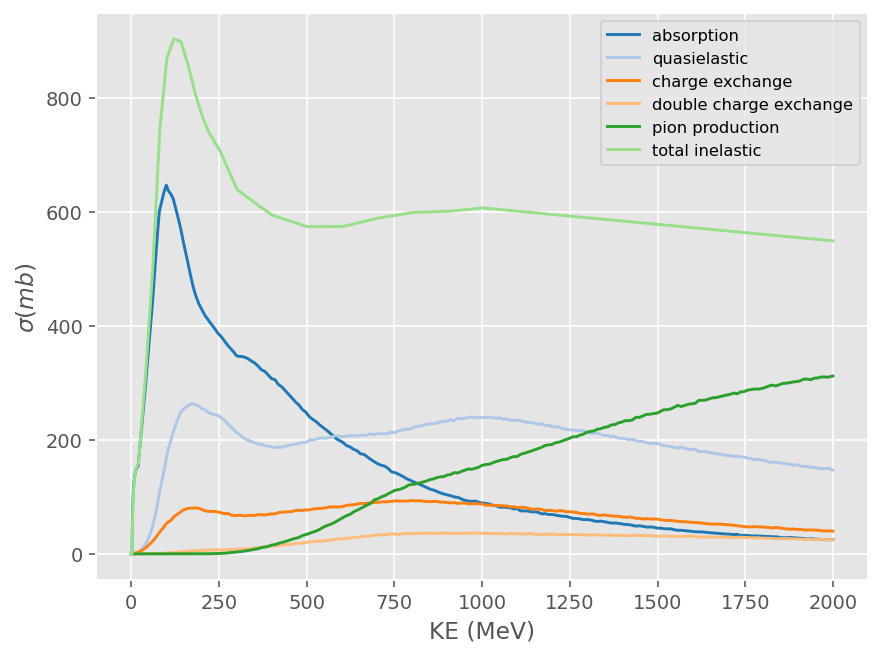

In [2]:
cross_sections = GeantCrossSections(energy_range = [0, 2000])
cross_sections.Plot("all")
# mplcyberpunk.add_glow_effects()


In [103]:
#events = LoadSample("work/ROOTFiles/PDSPAnalyser/PDSPProd4a_MC_1GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03.root", 149097)#149097
events = LoadSample("work/ROOTFiles/PDSPAnalyser/PDSPProd4a_MC_2GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03.root", 70774)#70774

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to filters.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to filename.
  warnings.warn(f"Couldn't apply filters to {var}.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Master.py:56: UserWarning: Couldn't apply filters to nTuple_type.
  warnings.warn(f"Couldn't apply filters to {var}.")


# Slices based on position

can slice up a TPC into thin slice targets based on the collection wire spacing.

By the conventions used by others, a single slice contains 20 wires, so is 10cm in thinkness (collection plane wire pitch is 5mm)

In [3]:
slices = Slices(10, -10, 720)

Now we do the counting experiment. the cross section in a single slice is:
$$
    \sigma = \frac{M_{Ar}}{\rho t N_{A}}\log\left( \frac{N_{incident}}{N_{incident} - N_{interact}} \right)
$$

 - $t$ is the thickness of each slice
 - $N_{incident}$ is the number of incident beam particles in the slice
 - $N_{interact}$ is the number of interacting beam particles in the slice (i.e. the end of the beam particle trajectory)

Alrogithm to count $N_{indicent}$ and $N_{interact}$ is as follows:

 1. Create `N_{indicent}` and `N_{interact}` bins for each slice.
 1. loop over each beam particle and find the end trajectory point
 2. calculate which slice the end trajectory point falls in `end_slice = floor(z/t)`
 3. add 1 to `end_slice` in `N_{interact}` bins and add 1 to every slice before and including `end_slice` in `N_{indicent}` (this makes the assumption the beam particle travelled through every slice before the final one.)


In [4]:
regions = truth_regions(events)
n_interact, n_incident = ThinSlice.CountingExperiment(events.trueParticles.endPos.z[:, 0], regions["total_inelastic"], slices) # using trajectory points gives wierd results, compare the two to see what is different.

print(f"{n_interact=}")
print(f"{n_incident=}")

plt.bar(slices.num[1:], n_incident, alpha = 0.5, label = "incident")
plt.bar(slices.num[1:], n_interact, alpha = 0.5, label = "interact", color = "C6")
plt.yscale("log")
plt.xlabel("slice number")
plt.ylabel("counts")
plt.legend()

def f(x):
    return (x + 0.5) * slices.width

def g(x):
    return x // slices.width

sax = plt.gca().secondary_xaxis("top", functions = (f, g))
sax.set_xlabel("interaction vertex z(cm)")


NameError: name 'events' is not defined

Plot the cross section as a function of slice number

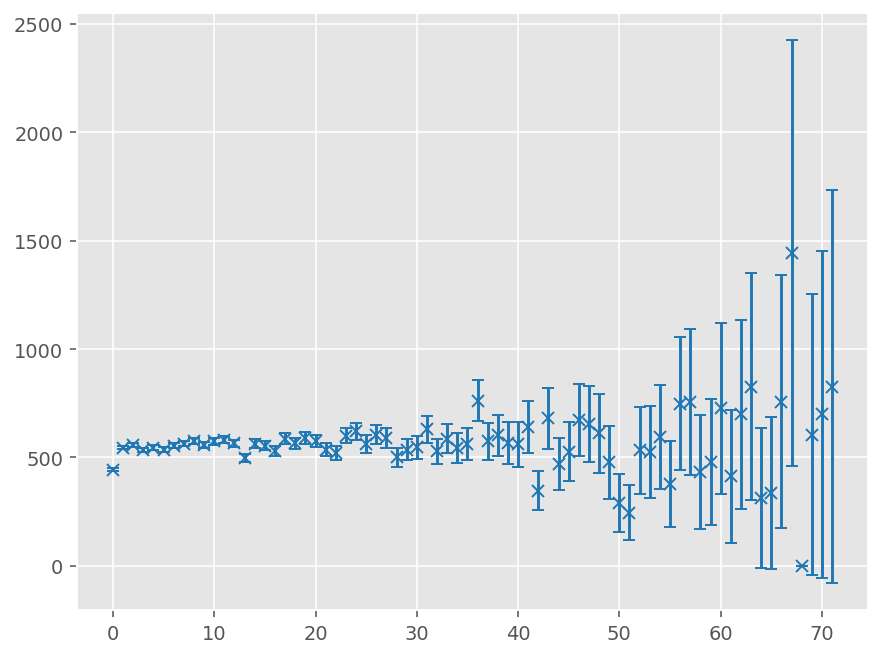

In [106]:
xs = ThinSlice.CrossSection(n_incident, n_interact, slices.width/0.95)
Plots.Plot(slices.num[1:-1], xs[0][:-1], yerr = xs[1][:-1], marker = "x", linestyle = "")

Plot the cross section as a function of the avergae $\pi^{+}$ Kinetic energy in each slice

Text(0.5, 0, 'interaction vertex z(cm)')

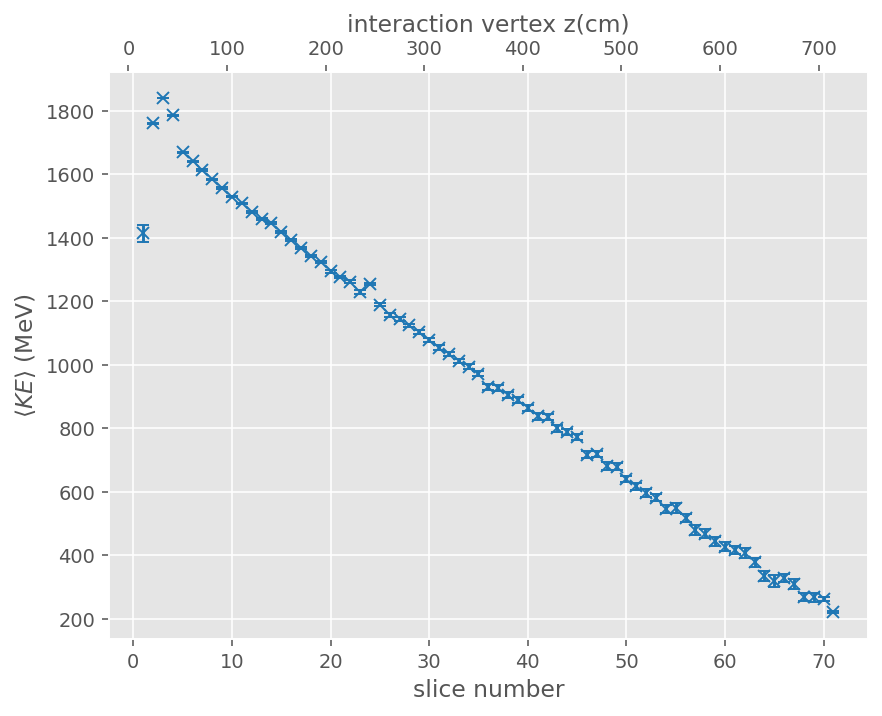

In [107]:
mean_energy, error_mean_energy = ThinSlice.MeanSliceEnergy(events.trueParticles.beam_traj_KE[regions["total_inelastic"]], events.trueParticles.beam_traj_pos.z[regions["total_inelastic"]], slices)

Plots.Plot(slices.num[2:-1], mean_energy[1:-1], yerr = error_mean_energy[1:-1], marker = "x", linestyle = "", xlabel = "slice number", ylabel = "$\left< KE \\right>$ (MeV)")
sax = plt.gca().secondary_xaxis("top", functions = (f, g))
sax.set_xlabel("interaction vertex z(cm)")

(0.0, 1200.0)

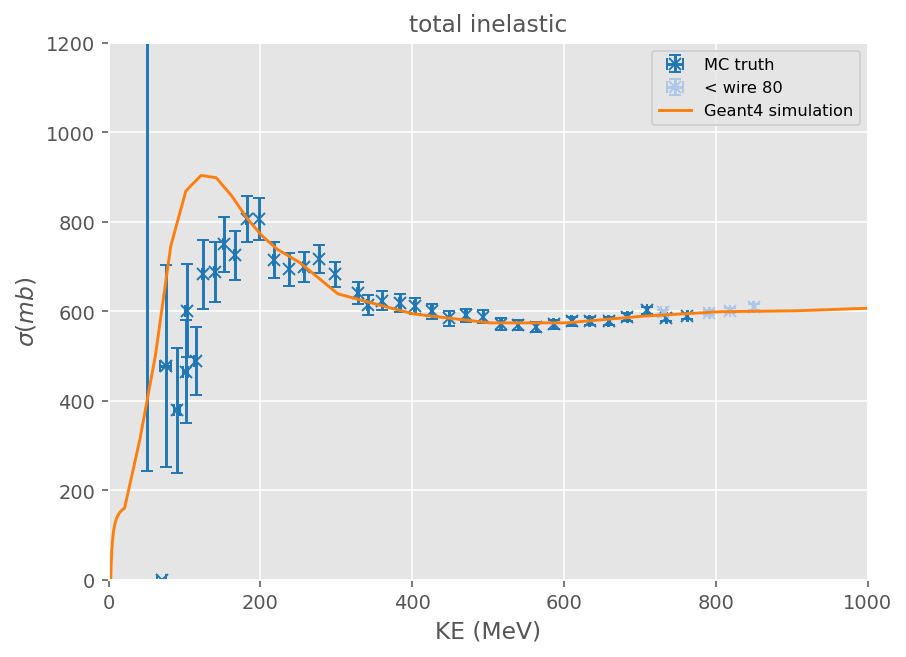

In [66]:
valid = slice(5, -1, 1) # past slice 5 (wire 80), there are issues with space charge effects in reco, so I highlighted them in this example, but for MC truth shouldn't be an issue.
low_wire = slice(1, 5, 1)

Plots.Plot(mean_energy[valid], xs[0][valid], xerr = error_mean_energy[valid], yerr = xs[1][valid], marker = "x", linestyle = "", label = "MC truth")
Plots.Plot(mean_energy[low_wire], xs[0][low_wire], xerr = error_mean_energy[low_wire], yerr = xs[1][low_wire], marker = "x", linestyle = "", label = "< wire 80", newFigure = False)
cross_sections.Plot("total_inelastic", color = "C2", label = "Geant4 simulation")

plt.xlim(0, 1000)
plt.ylim(0, 1200)

evaluating total_inelastic region

evaluating absorption region

evaluating charge_exchange region

evaluating quasielastic region

[1000.0, 2000.0, 0.0, 400.0]

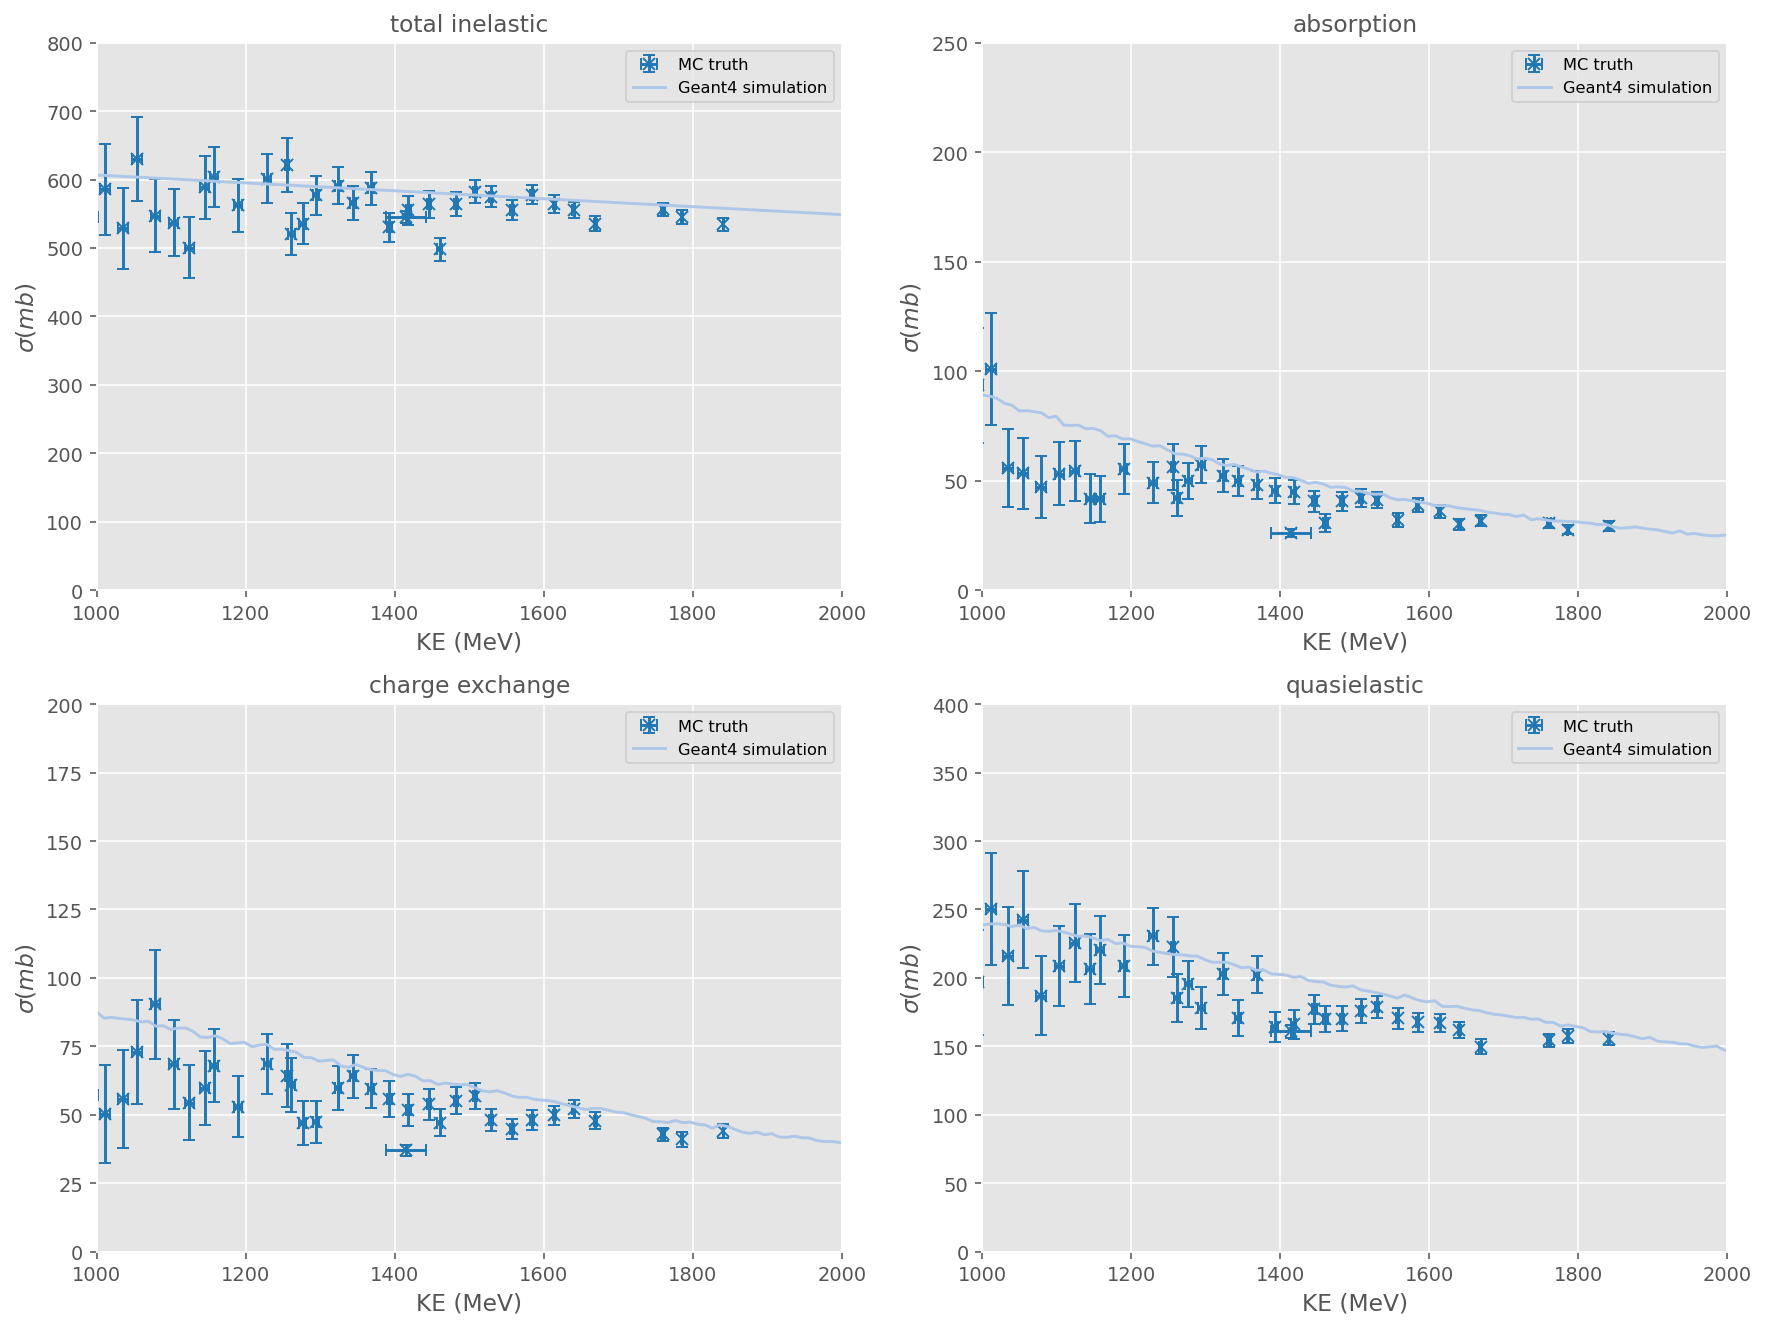

In [114]:
ThinSliceDemo(events, [-10, 720], [1000, 2000], 10)

plt.setp(plt.gcf().axes[0], xlim = [1000, 2000], ylim = [0, 800])
plt.setp(plt.gcf().axes[1], xlim = [1000, 2000], ylim = [0, 250])
plt.setp(plt.gcf().axes[2], xlim = [1000, 2000], ylim = [0, 200])
plt.setp(plt.gcf().axes[3], xlim = [1000, 2000], ylim = [0, 400])


In [98]:
for i, s in Plots.IterMultiPlot(slices):
    mask = slices.pos_to_num(events.trueParticles.beam_traj_pos.z) == s.num
    energy = events.trueParticles.true_beam_traj_KE[mask]
    Plots.PlotHist(ak.ravel(energy), newFigure = False, title = s.__str__(), range = [0, 1500], xlabel = "True Kinetic Energy (MeV)")

# Slices Based on Energy

instead of computing the slices based on the wire pitch, use the energy loss of the particle and define slices in energy instead. This means the slice thickness is now in terms of $\delta E$ and the spacial thickness is:

$$
    t_{i} = \frac{\delta E}{ \left.\frac{dE}{dX}\right|_{\left< E_{i} \right>} }
$$

where i is the slice number, $dE/dX$ is the energy loss per unit length and $E_{i}$ is the particle energy exiting the slice.

i.e. the slice thickness is the distance the particle travels before it looses $\delta E$ worth of energy.

Now the cross section formula becomes:

$$
\sigma_{i} = \frac{M_{Ar}}{\rho N_{A} \delta E} \left.\frac{dE}{dX}\right|_{\left< E_{i} \right>} \log\left( \frac{N_{incident}}{N_{incident} - N_{interact}} \right)
$$

And really is a function of the particle kinetic energy rather than the averge kinetic energy in a slice.

By convention, $\delta E$ is set to 50MeV (not sure why) and now the slice thickness need to be calculated per particle

Now, the counting will work in a similar way, but we can no longer assume the particle travels through all slices because the initial kinetic energy of the beam particle vill vary. So as well as the end slice, an initial slice must be found.

The initial slice is `ceil((plim - KE_ini)//dE)`

The end slice is still the last trajectory point, but the slice number needs to be found based on the energy the particle had before interacting with the target

870.1225800481984

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/cross_section.py:154: RuntimeWarning: invalid value encountered in double_scalars
  beta = (1 - (1/gamma)**2)**0.5


-44.135129713718406

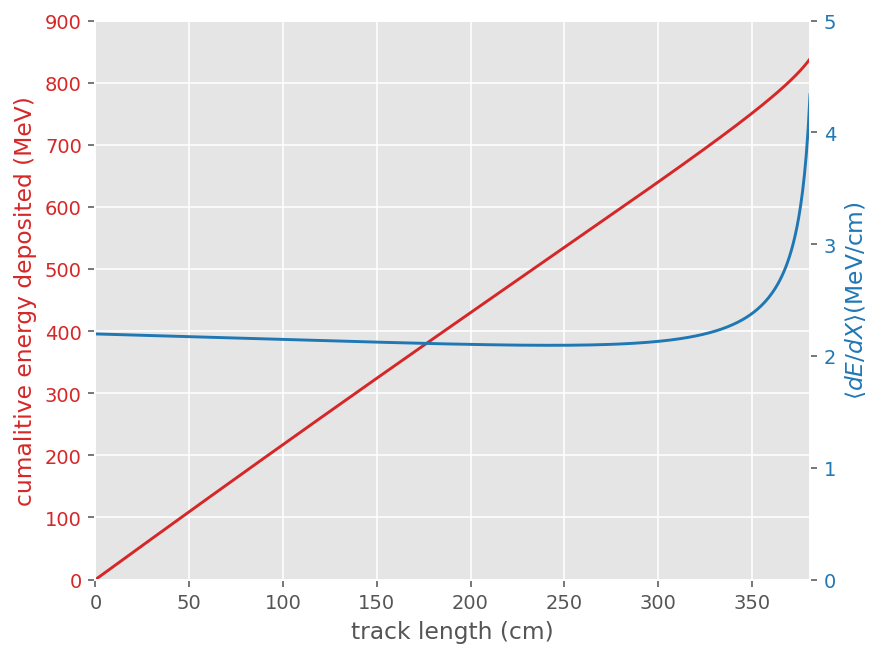

In [83]:
KE = ((1000)**2 + (Particle.from_pdgid(211).mass)**2)**0.5 - Particle.from_pdgid(211).mass
print(KE)
total_energy_deposited = [0]
dEdX = [cross_section.BetheBloch.meandEdX(KE, Particle.from_pdgid(211))]

pitch = 1 # cm

while KE > 0:
    total_energy_deposited.append(total_energy_deposited[-1] + dEdX[-1] * pitch)
    KE -= dEdX[-1] * pitch
    dEdX.append(cross_section.BetheBloch.meandEdX(KE, Particle.from_pdgid(211)))
print(KE)

total_energy_deposited = np.array(total_energy_deposited)
dEdX = np.array(dEdX)

trk_len = np.arange(0, pitch * len(dEdX), pitch)

dEdX = dEdX[trk_len <= 381]
total_energy_deposited = total_energy_deposited[trk_len <= 381]
trk_len = trk_len[trk_len <= 381]

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('track length (cm)')
ax1.set_ylabel('cumalitive energy deposited (MeV)', color=color)
ax1.plot(trk_len, total_energy_deposited, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel("$\left<dE/dX\\right>$(MeV/cm)", color=color)  # we already handled the x-label with ax1
ax2.plot(trk_len, dEdX, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.grid(False)

ax1.set_ylim(0, 900)
ax2.set_ylim(0, 5)
plt.xlim(0, 381)

fig.tight_layout()  # otherwise the right y-label is slightly clipped


(2.0, 5.2)

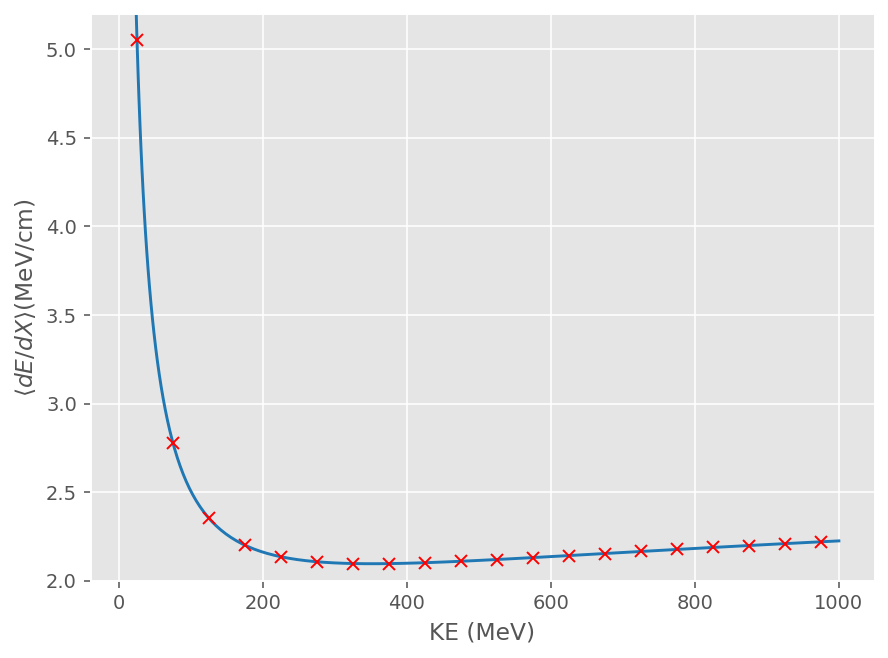

In [84]:
Plots.Plot(np.logspace(1, 3, 100), cross_section.BetheBloch.meandEdX(np.logspace(1, 3, 100), Particle.from_pdgid(211)))
Plots.Plot(np.arange(0, 1000, 50) + 25, cross_section.BetheBloch.meandEdX(np.arange(0, 1000, 50) + 25, Particle.from_pdgid(211)), marker = "x", color = "red", newFigure = False, linestyle = "", xlabel = "KE (MeV)", ylabel = "$\left<dE/dX\\right>$(MeV/cm)")
plt.ylim(2, 5.2)

In [117]:
def ff_KE():
    """ Calculate the true front facing kinetic energy.
        If the particle never reaches the TPC, it is assigned 999999.
        Note this method gives a larger kinetic enrgy than if you interpolate between the fist and last points (not sure why).

    Returns:
        ak.Array: true front facing kinetic energy
    """
    ind = ak.argmax(events.trueParticles.beam_traj_pos.z > 0, 1, keepdims = True) # first trajectory point in the TPC

    dist = vector.dist(events.trueParticles.beam_traj_pos[ind], events.trueParticles.beam_traj_pos[ind-1]) # distance from the first point in the TPC and last point outside the TPC

    dist = dist * events.trueParticles.beam_traj_pos.z[ind] / (events.trueParticles.beam_traj_pos.z[ind] - events.trueParticles.beam_traj_pos.z[ind - 1]) # weight the dist by the ratios of z to get the distance from the front face of the TPC (slighly more accurate than just doing z[i] - z[i-1])

    f_KE = events.trueParticles.beam_traj_KE[ind] # get the kinetic energy at the first trajectory point
    f_KE = ak.where(ak.flatten(events.trueParticles.beam_traj_pos.z[ind] < 0), 999999, f_KE) # set first KE to zero if the particle didn't reach the TPC.

    dEdX = cross_section.BetheBloch.meandEdX(f_KE, Particle.from_pdgid(211)) # mean dEdX to extrapolate the front facing Kinetic energy
    return ak.flatten(f_KE + dist * dEdX)

ind = ak.argmax(events.trueParticles.beam_traj_pos.z > 0, -1, True) # first trajectory point in the TPC
true_int_KE = events.trueParticles.beam_traj_KE[:, -2] # -1 is always zero for kinetic energy trajectory points, to take -2

true_ffKE = ak.flatten(events.trueParticles.beam_traj_KE[ind]) # first kinetic energy point as proxy for ff_KE #!(interpolation can be used to get a more accurate ff_KE)
true_ffKE = ak.where(ak.flatten(events.trueParticles.beam_traj_pos.z[ind] < 0), 999999, true_ffKE) ## set KE to 999999 if the particle didn't reach the TPC.
# true_ffKE = ff_KE() #! see function comments

energy_slices = Slices(20, 0, 2000, reversed = True)

print(f"{true_int_KE=}")
print(f"{true_ffKE=}")

true_int_KE=<Array [1.82e+03, 1.56e+03, ... 1.81e+03] type='44169 * float64'>

true_ffKE=<Array [1.83e+03, 1.73e+03, ... 1.82e+03] type='44169 * ?float64'>

np.unique(true_init_slice, return_counts=True)=(array([ -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10, 
11,
        12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
        25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  36,  38,  39,
        40,  41,  42,  45,  51,  52,  53,  55,  60,  61,  62,  64,  67,
        69,  70,  71,  72,  73,  74,  75,  77,  78,  80,  81,  82,  83,
        84,  85,  86,  87,  89,  92,  93,  95,  97,  99, 100]), array([6477, 1360, 1629, 2014, 2192, 2522, 2499, 
2592, 2754, 2738, 2716,
       2518, 2326, 2095, 1895, 1460, 1139,  829,  643,  479,  358,  222,
        182,  119,   78,   63,   44,   34,   14,   15,   11,    6,    5,
          1,    4,    3,    3,    2,    1,    2,    2,    1,    2,    2,
          1,    1,    2,    1,    1,    1,    1,    1,    3,    2,    3,
          1,    1,    4,    2,    1,    1,    2,    4,    3,    3,    5,
          3,    1,    2,    4,    1,    1,    2,    1,    1,   58]))

np.unique(true_int_slice, return_counts=True)=(array([ -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  
11,
        12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
        25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
        38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
        51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
        64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  98, 100]), array([3419,  494,  568,  716,  894,  971, 1206, 1388, 1560, 
1544, 1639,
       1791, 1801, 1870, 1783, 1874, 1731, 1585, 1514, 1432, 1373, 1262,
       1030, 1030,  955,  825,  785,  658,  601,  572,  535,  438,  436,
        358,  335,  318,  295,  253,  237,  196,  179,  162,  135,  127,
        132,  114,   97,  102,   63,   82,   57,   61,   50,   42,   34,
         42,   43,   35,   19,   33,   34,   15,   17,   14,    6,   15,
         13,    6,   11,   11,   11,    7,   10,    3,    7,    3,    3,
          1,    6,    9,    4,    5,    6,    6,    3,    4,    7,    3,
          2,    3,    7,    1,    1,    3,    3,    4,    4,    4,    1,
         15]))

Text(0.5, 0, 'KE (MeV)')

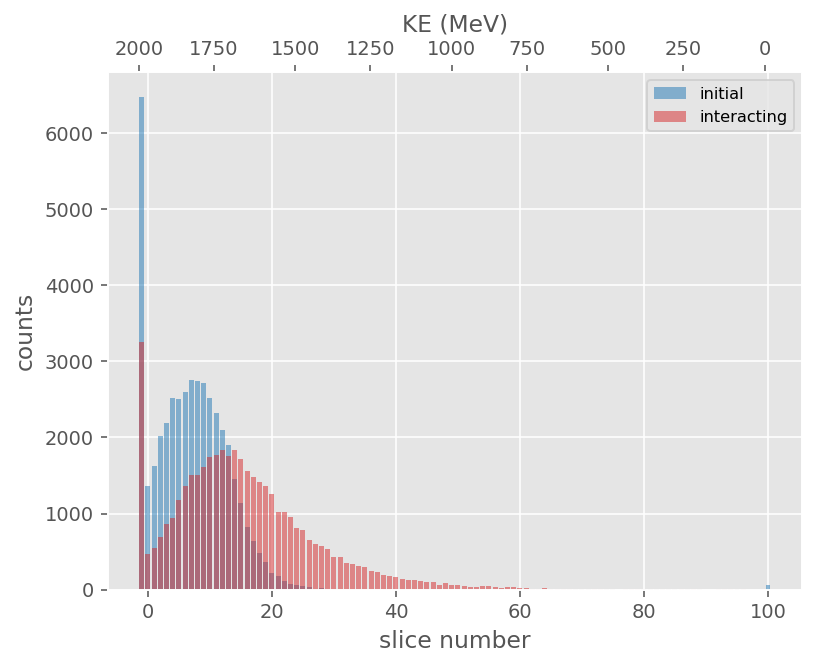

In [118]:
regions = truth_regions(events)

true_init_slice = energy_slices(true_ffKE).num + 1 # equivilant to ceil
true_int_slice = energy_slices(true_int_KE).num

true_init_slice = EnergySlice.TrunacteSlices(true_init_slice, energy_slices)
true_int_slice = EnergySlice.TrunacteSlices(true_int_slice, energy_slices)

# just in case we encounter an instance where E_int > E_ini (unphysical)
bad_slices = true_int_slice < true_init_slice
true_init_slice = ak.where(bad_slices < 0, -1, true_init_slice)
true_int_slice = ak.where(bad_slices, -1, true_int_slice)

print(f"{np.unique(true_init_slice, return_counts=True)=}")
print(f"{np.unique(true_int_slice, return_counts=True)=}")

plt.bar(*np.unique(true_init_slice, return_counts = True), alpha = 0.5, label = "initial")
plt.bar(*np.unique(true_int_slice[regions["total_inelastic"]], return_counts = True), alpha = 0.5, color = "C6", label = "interacting")
plt.xlabel("slice number")
plt.ylabel("counts")
plt.legend()

def f(x):
    return (energy_slices.max_num - x - 1.5) * energy_slices.width

def g(x):
    return ((energy_slices.max - x) // energy_slices.width) + 1.5

sax = plt.gca().secondary_xaxis("top", functions = (f, g))
sax.set_xlabel("KE (MeV)")

[ 3517  4691  6165  7687  9381 10955 12394 13806 15050 16256 17178 17762
 18074 18125 17831 17125 16280 15390 14394 13356 12225 11172 10284  9343
  8463  7682  6936  6295  5715  5157  4631  4200  3767  3415  3084  2766
  2474  2221  1987  1792  1615  1455  1321  1194  1063   951   854   753
   691   609   553   494   444   403   370   332   289   256   237   205
   171   157   141   129   125   111    98    93    83    77    70    67
    58    56    52    51    49    50    45    36    34    33    31    31
    32    31    26    25    23    24    18    17    18    16    14    14
    10     8     8     8     8]

[ 347  436  553  705  799 1011 1170 1337 1353 1441 1598 1640 1716 1650
 1755 1618 1478 1423 1360 1321 1220  986 1006  931  810  771  647  593
  563  530  433  431  353  330  315  291  250  232  195  179  160  135
  127  128  113   94  101   62   81   54   60   50   40   33   39   43
   33   19   32   33   14   16   12    5   14   13    6   10    9    9
    6   10    3    7    3    2    0    6    9    4    5    5    2    3
    3    6    3    2    2    6    1    0    3    2    2    4    2    0
    1    0 2923]

Text(0.5, 0, 'KE (MeV)')

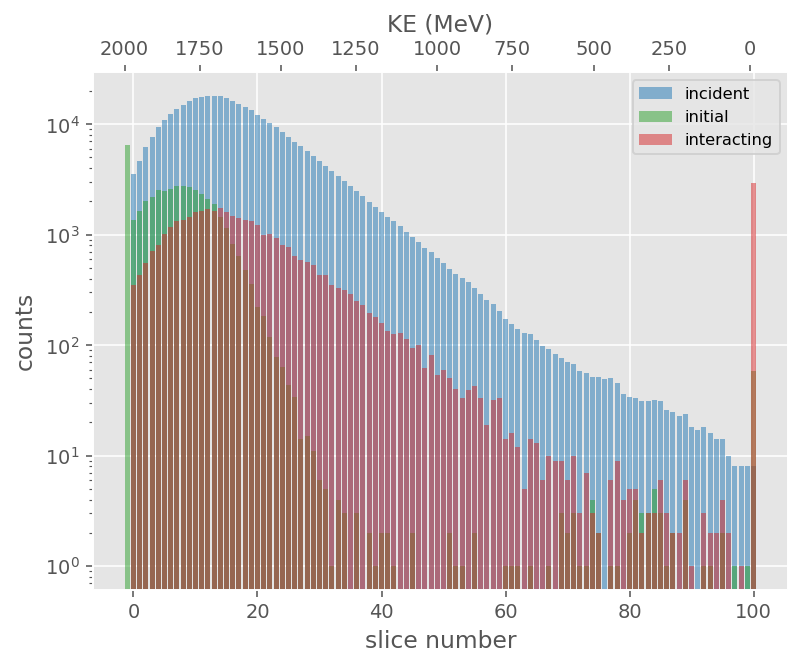

In [119]:
outside_tpc = true_ffKE >= 999999 # don't count events outside the TPC
n_interact, n_incident = EnergySlice.CountingExperiment(true_int_KE, true_ffKE, outside_tpc, regions["total_inelastic"], energy_slices)

print(n_incident)
print(n_interact)

plt.bar(energy_slices.num, n_incident, alpha = 0.5, label = "incident")
plt.bar(*np.unique(true_init_slice, return_counts = True), color = "C4", alpha = 0.5, label = "initial")
plt.bar(energy_slices.num, n_interact, alpha = 0.5, color = "C6", label = "interacting")
plt.xlabel("slice number")
plt.ylabel("counts")
plt.yscale("log")
plt.legend()

def f(x):
    return (energy_slices.max_num - x - 1.5) * energy_slices.width

def g(x):
    return ((energy_slices.max - x) // energy_slices.width) + 1.5

sax = plt.gca().secondary_xaxis("top", functions = (f, g))
sax.set_xlabel("KE (MeV)")


/tmp/ipykernel_35413/1320162809.py:300: RuntimeWarning: invalid value encountered in log
  xs = np.log(n_incident / (n_incident - n_interact)) # calculate a dimensionless cross section


(0.0, 1200.0)

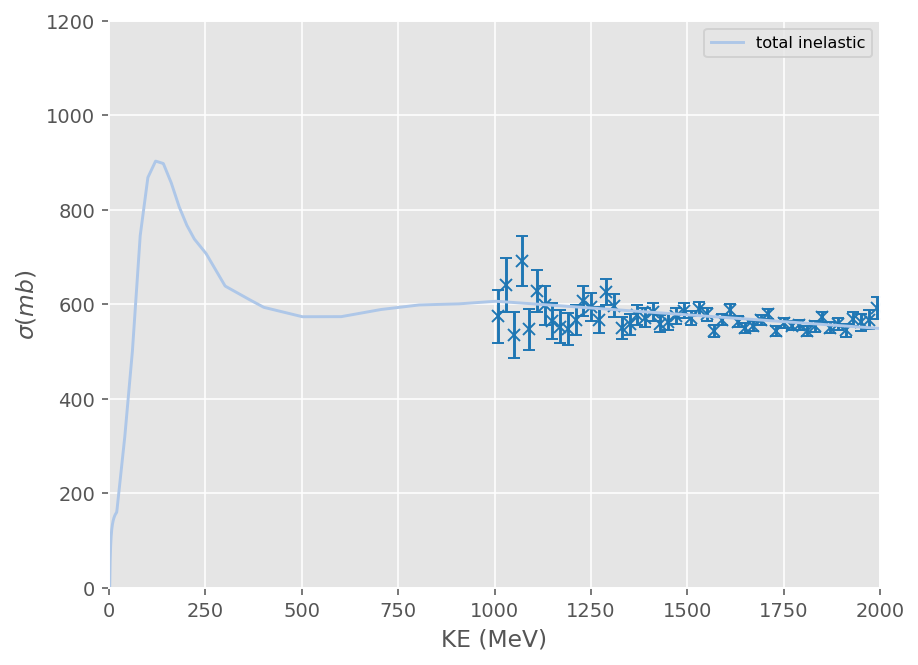

In [455]:
dEdX = EnergySlice.Slice_dEdX(energy_slices, Particle.from_pdgid(211))
xs = EnergySlice.CrossSection(n_interact, n_incident, dEdX, energy_slices.width)

Plots.Plot(energy_slices.pos - energy_slices.width/2, xs[0], yerr = xs[1], marker = "x", linestyle = "")

cross_sections.Plot("total_inelastic")
plt.xlim(0, energy_slices.max)
plt.ylim(0, 1200)

evaluating total_inelastic region

/tmp/ipykernel_18833/1177387323.py:300: RuntimeWarning: invalid value encountered in log
  xs = np.log(n_incident / (n_incident - n_interact)) # calculate a dimensionless cross section


evaluating absorption region

evaluating charge_exchange region

evaluating quasielastic region

[1000.0, 2000.0, 0.0, 400.0]

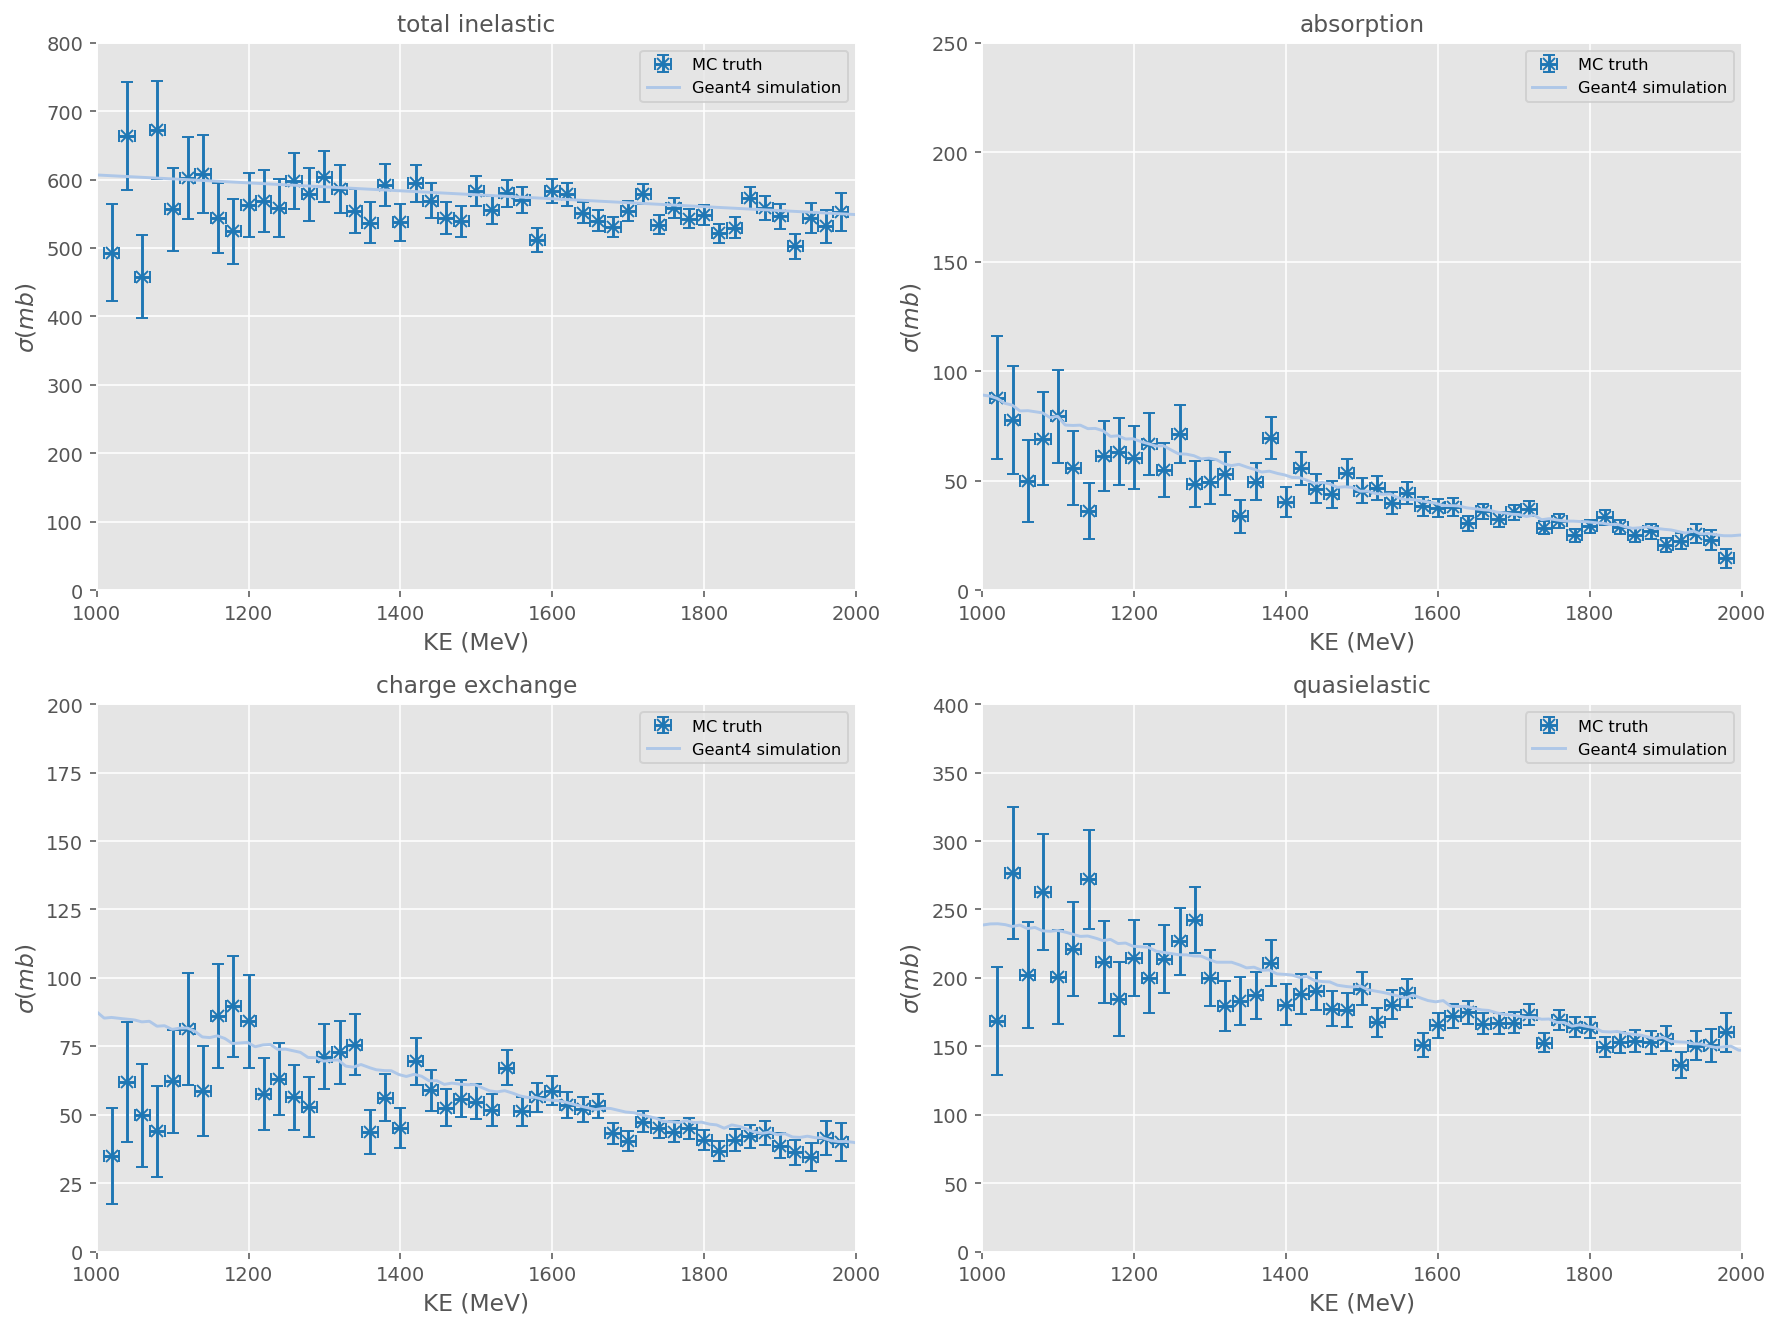

In [123]:
EsliceDemo(events, 980, 2000, 20)

plt.setp(plt.gcf().axes[0], xlim = [1000, 2000], ylim = [0, 800])
plt.setp(plt.gcf().axes[1], xlim = [1000, 2000], ylim = [0, 250])
plt.setp(plt.gcf().axes[2], xlim = [1000, 2000], ylim = [0, 200])
plt.setp(plt.gcf().axes[3], xlim = [1000, 2000], ylim = [0, 400])


In [374]:
https://indico.fnal.gov/event/52248/
https://indico.fnal.gov/event/52663/contributions/232060/attachments/150781/194577/Hadron%20Meeting%201_13_22.pdf
https://indico.fnal.gov/event/52248/contributions/230130/attachments/150183/193605/Hadron%20Analysis%20Meeting%209%20Dec%202021.pdf
https://indico.fnal.gov/event/47844/contributions/208964/attachments/140192/176119/xs_validation_mcTrue_Prod4_02_18_21.pdf
https://indico.fnal.gov/event/54192/contributions/239696/attachments/154284/200404/Hadron%20Meeting%204-21-22.pdf
https://indico.fnal.gov/event/47844/contributions/208964/attachments/140192/176119/xs_validation_mcTrue_Prod4_02_18_21.pdf
https://indico.fnal.gov/event/55164/contributions/245011/attachments/156673/204588/pionXS_HadAna_220630.pdf

https://indico.fnal.gov/event/54122/contributions/239293/attachments/154088/200097/Hadron%20Meeting%204-14-22.pdf

https://indico.fnal.gov/event/53325/contributions/235193/attachments/152412/197326/pionXS_DRA_220223.pdf

[None, None, None, None, None]

# Combined Study

In [141]:
def ThinSliceResults(events : Master.Data, slices : Slices, regions : dict) -> dict:
    """ Do Thin slice study for MC truth.

    Args:
        events (Master.Data): events to look at
        slices (Slices): spatial slices
        regions (dict): truth regions

    Returns:
        dict: cross sections for each region.
    """
    interact_position = events.trueParticles.endPos.z[:, 0]
    xs = {}
    for r in regions:
        n_interact, n_incident = ThinSlice.CountingExperiment(interact_position, regions[r], slices)
        xs[r] = ThinSlice.CrossSection(n_incident, n_interact, slices.width/ 0.95)
    return xs


def ThinSliceMeanEnergy(events : Master.Data, slices : Slices, regions : dict) -> tuple[ak.Array, ak.Array]:
    """ mean energy for each thin slice.

    Args:
        events (Master.Data): events to look at
        slices (Slices): spatial slices
        regions (dict): truth regions

    Returns:
        tuple[ak.Array, ak.Array]: _description_
    """
    traj_KE = events.trueParticles.beam_traj_KE
    traj_pos = events.trueParticles.beam_traj_pos.z

    mean_slice_energy = ThinSlice.MeanSliceEnergy(traj_KE[regions["total_inelastic"]], traj_pos[regions["total_inelastic"]], slices)
    return mean_slice_energy


def EnergySliceResults(events : Master.Data, slices : Slices, regions : dict) -> dict:
    """ Do Energy slice study for MC truth.

    Args:
        events (Master.Data): events to look at
        slices (Slices): energy slices
        regions (dict): truth regions

    Returns:
        dict: _description_
    """
    ind = ak.argmax(events.trueParticles.beam_traj_pos.z > 0, -1, True) # first trajectory point in the TPC
    true_int_KE = events.trueParticles.beam_traj_KE[:, -2] # -1 is always zero for kinetic energy trajectory points, to take -2

    true_ffKE = ak.flatten(events.trueParticles.beam_traj_KE[ind]) # first kinetic energy point as proxy for ff_KE #!(interpolation can be used to get a more accurate ff_KE)
    true_ffKE = ak.where(ak.flatten(events.trueParticles.beam_traj_pos.z[ind] < 0), 999999, true_ffKE) # set KE to 999999 if the particle didn't reach the TPC.
    outside_tpc = true_ffKE >= 999999 # don't count events outside the TPC

    mean_dEdX = EnergySlice.Slice_dEdX(energy_slices, Particle.from_pdgid(211))

    xs = {}
    for r in regions:
        n_interact, n_incident = EnergySlice.CountingExperiment(true_int_KE, true_ffKE, outside_tpc, regions[r], energy_slices)
        xs[r] = EnergySlice.CrossSection(n_interact, n_incident, mean_dEdX, energy_slices.width)

    return xs


samples = {
    "1GeV" : LoadSample("work/ROOTFiles/PDSPAnalyser/PDSPProd4a_MC_1GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03.root", 149097),#149097
    "2GeV" : LoadSample("work/ROOTFiles/PDSPAnalyser/PDSPProd4a_MC_2GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03.root", 70774)#70774
}

cross_sections = GeantCrossSections(energy_range = [0, 2000])
slices = Slices(10, -10, 720) # cm
energy_slices = Slices(20, 0, 2000, reversed = True) # MeV, slice 0 is high energy 

regions = {s : truth_regions(samples[s]) for s in samples}


/tmp/ipykernel_18833/4056152503.py:300: RuntimeWarning: invalid value encountered in divide
  xs = np.log(n_incident / (n_incident - n_interact)) # calculate a dimensionless cross section
/tmp/ipykernel_18833/4056152503.py:303: RuntimeWarning: invalid value encountered in divide
  v_interact = n_interact*(1- (n_interact/n_incident)) # binomial uncertainty
/tmp/ipykernel_18833/4056152503.py:305: RuntimeWarning: divide by zero encountered in divide
  xs_e = (1/n_incident) * (1/(n_incident - n_interact)) * (n_interact**2 * v_incident + n_incident**2 * v_interact)**0.5
/tmp/ipykernel_18833/4056152503.py:292: RuntimeWarning: invalid value encountered in divide
  mean_energy = sum_energy / counts
/tmp/ipykernel_18833/4056152503.py:294: RuntimeWarning: invalid value encountered in divide
  std_energy = np.sqrt(sum_energy_sqr/counts - 2 * mean_energy * sum_energy / counts + mean_energy**2) # expanded standard deviation so I can calulcate using the histograms


0 total_inelastic

1 absorption

2 charge_exchange

3 quasielastic

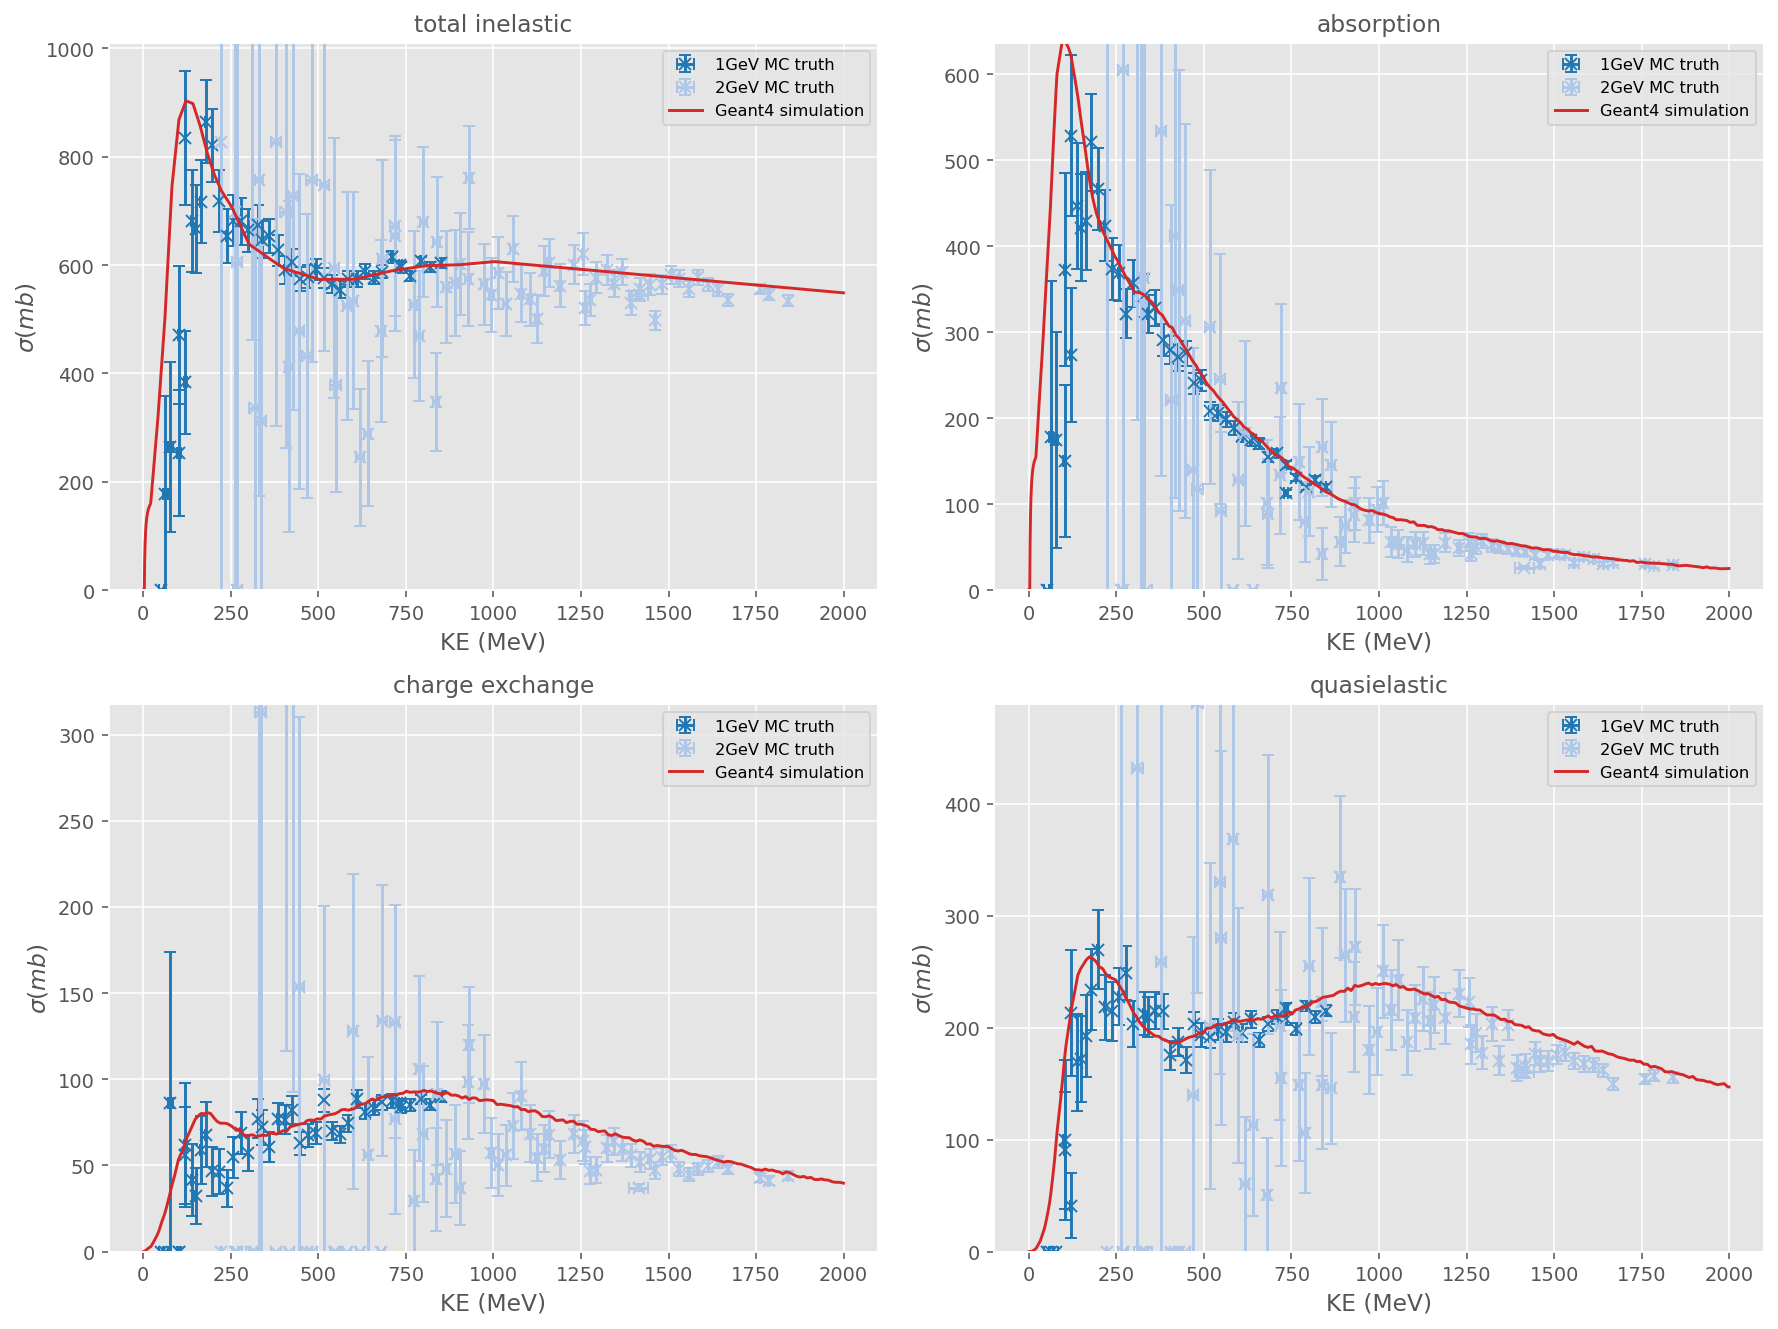

In [152]:
t_xs = {s: ThinSliceResults(samples[s], slices, regions[s]) for s in samples}
t_e = {s : ThinSliceMeanEnergy(samples[s], slices, regions[s]) for s in samples}

for i, r in Plots.IterMultiPlot(regions["1GeV"], True, False):
    print(i, r)
    for s in samples:
        Plots.Plot(t_e[s][0][1:-1], t_xs[s][r][0][1:-1], yerr = t_xs[s][r][1][1:-1], xerr = t_e[s][1][1:-1], xlabel = "average $\pi^{+}$ kinetic energy before interacting (MeV)", ylabel = "$\sigma$(mb)", linestyle = "", marker = "x", newFigure = False, label = s + " MC truth")
    cross_sections.Plot(r, label = "Geant4 simulation", color = "C6")
    plt.ylim(0, 0.7 * max(t_xs[s][r][0][1:-1]))

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/cross_section.py:154: RuntimeWarning: invalid value encountered in sqrt
  beta = (1 - (1/gamma)**2)**0.5
/home/sb16165/anaconda3/envs/python3_10_0/lib/python3.10/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: divide by zero encountered in divide
  result = getattr(ufunc, method)(
/tmp/ipykernel_18833/4056152503.py:300: RuntimeWarning: invalid value encountered in divide
  xs = np.log(n_incident / (n_incident - n_interact)) # calculate a dimensionless cross section
/tmp/ipykernel_18833/4056152503.py:300: RuntimeWarning: invalid value encountered in log
  xs = np.log(n_incident / (n_incident - n_interact)) # calculate a dimensionless cross section
/tmp/ipykernel_18833/4056152503.py:303: RuntimeWarning: invalid value encountered in divide
  v_interact = n_interact*(1- (n_interact/n_incident)) # binomial uncertainty
/tmp/ipykernel_18833/4056152503.py:305: RuntimeWarning: divide by zero encountered in divide
  xs_e

0 total_inelastic

1 absorption

2 charge_exchange

3 quasielastic

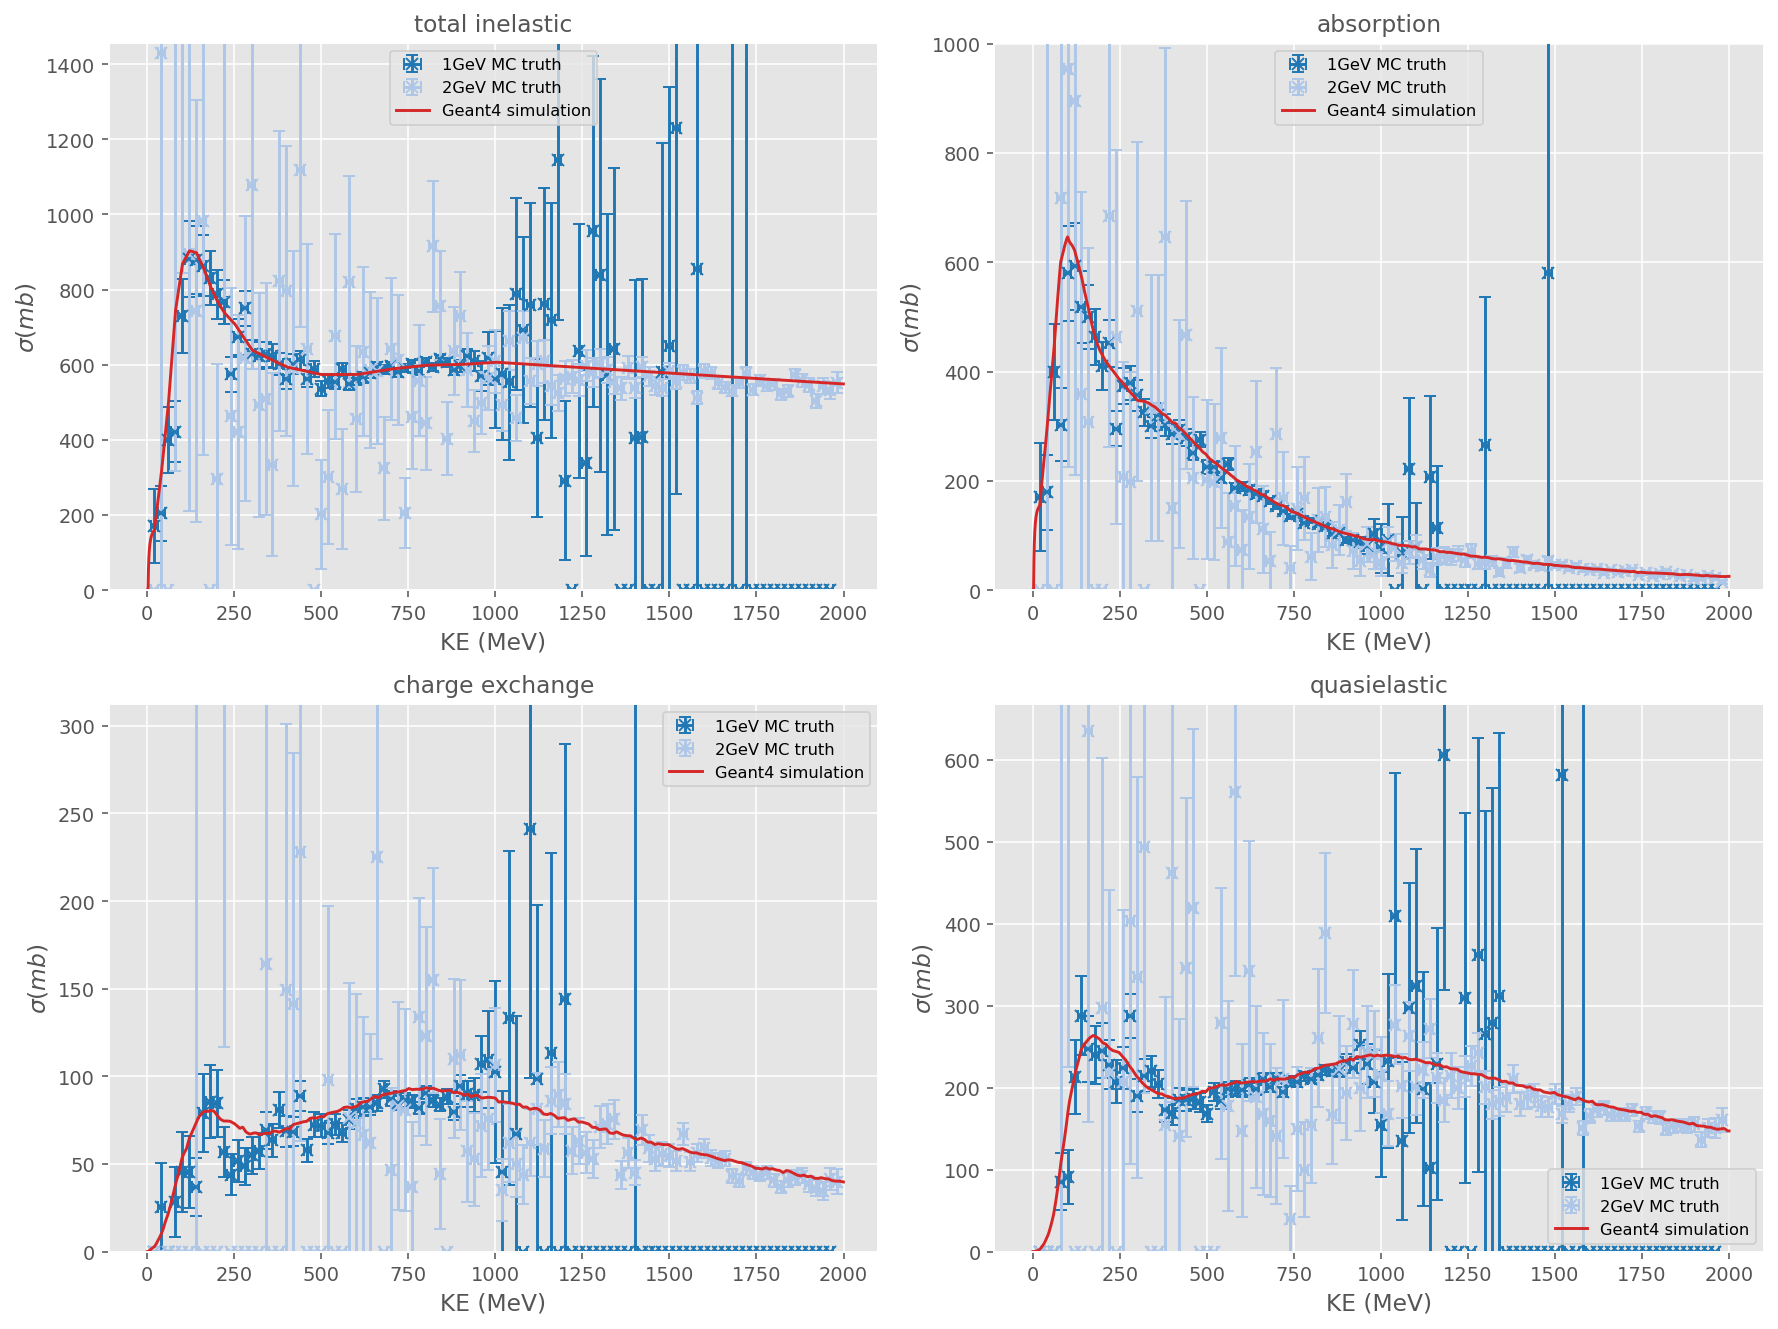

In [153]:
e_xs = {s: EnergySliceResults(samples[s], slices, regions[s]) for s in samples}

for i, r in Plots.IterMultiPlot(regions["1GeV"], True, False):
    print(i, r)
    for s in samples:
        Plots.Plot(energy_slices.pos[1:], e_xs[s][r][0][1:], yerr = e_xs[s][r][1][1:], xerr = energy_slices.width/2, xlabel = "average $\pi^{+}$ kinetic energy before interacting (MeV)", ylabel = "$\sigma$(mb)", linestyle = "", marker = "x", newFigure = False, label = s + " MC truth")
    cross_sections.Plot(r, label = "Geant4 simulation", color = "C6")
    plt.ylim(0, 0.7 * max(e_xs[s][r][0][1:]))

In [ ]:
# Plots.Plot(energy_slices.pos[1:], xs[0][1:], yerr = xs[1][1:], xerr = energy_slices.width/2, marker = "x", linestyle = "", newFigure = False, label = "MC truth", xlabel = "KE (MeV)", ylabel = "$\sigma$(mb)")
# cross_sections.Plot(region, label = "Geant4 simulation")
# plt.xlim(e_min - e_width, e_max + e_width)

Create thin slices:
 - get all energy depositions made in the collection plane by the beam particle (in Analyser this is view2_IDEs)
 - get the wire pitch in the collection plane (this should be fixed)
 - slice the IDEs by the wire pitch:
   ```c++    
      std::map<int, std::vector<const sim::IDE*>> results; // create a map of slide ID numbers and the ides which fall into this slice

      for (size_t i = 0; i < ides.size(); ++i) {
         int slice_num = std::floor((ides[i]->z - (the_z0 - the_pitch/2.)) / the_pitch); // calculate the slice number for this IDE
         results[slice_num].push_back(ides[i]); // push the IDE into it's relevant slice
   ```
   The formula for calculating the slice number is
   $$
      slice\_num = floor\left(\frac{ide_{z} - z_{0} - \frac{1}{2}pitch}{pitch}\right)
   $$

Create thin tragets:
 - get the initial kinetic energy of the beam particle:
   $$
      KE_{ini} = \sqrt(p^{2} + m^{2}) - m;
   $$
   this is calculated in two ways (for some reason):
   ```c++
     double init_KE = sqrt(1.e6 * true_beam_startP*true_beam_startP +
                        true_beam_mass*true_beam_mass) - true_beam_mass;
   ```
   This uses simb:MCParticle properties
   ```c++
   init_KE = 1.e3 * true_beam_trajectory.E(i-1) - true_beam_mass;
   ```
   This uses the energy in the trajectory point before the first ide in the first slice.
 - loop thorugh all slices
 - calculate the energy deposited in this slice by summing energies of all ides in this slice
 - calculate the incidient energy in this slice, the first incident energy is $KE_{ini}$:
   $$
      KE_{inc, i} = KE_{inc, i-1} - \delta E_{i}
   $$